In [15]:
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule # PySCFDriver
from qiskit_nature.drivers.second_quantization import PySCFDriver, MethodType
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.algorithms import GroundStateEigensolver, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms.pes_samplers import EnergySurface1DSpline

from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit.circuit.library import TwoLocal

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP

import numpy as np
from functools import partial as pair_variation
import matplotlib.pyplot as plt

from qiskit import IBMQ, assemble, transpile

In [16]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

In [17]:
variation = Molecule.absolute_stretching
variation = Molecule.absolute_distance
specific_variation = pair_variation(variation, atom_pair=(1, 0))

ethene = Molecule(geometry=
                    [['C', [-0.654, 0.034, 0.]],
                     ['C', [0.654, -0.034, 0.]],
                     ['H', [-1.149, 1.005, 0.]],
                     ['H', [-1.247, -0.880, 0.]],
                     ['H', [1.247, 0.880, 0.]],
                     ['H', [1.149, -1.005, 0.]]],
                     charge=0,degrees_of_freedom=[specific_variation], multiplicity=1,
                      masses=[1.99442348e-26, 1.99442348e-26, 1.6735328e-27, 1.6735328e-27, 1.6735328e-27, 1.6735328e-27])

H = Molecule(geometry=
             [['H', [0., 0., 0.2]],
              ['H', [0., 0., 0.]]],
             degrees_of_freedom=[specific_variation],
             masses=[1.6735328e-27, 1.6735328e-27])

/tmp/ipykernel_140/4063947443.py:13: DeprecationWarning: __init__ keyword argument gss is deprecated and replaced with state_solver.
  bs = BOPESSampler(gss=me_gss, bootstrap=True)


Text(0, 0.5, 'Energy')

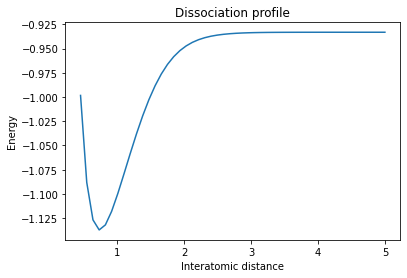

In [4]:
qubit_converter = QubitConverter(mapper=JordanWignerMapper())
quantum_instance = QuantumInstance(backend=Aer.get_backend("aer_simulator_statevector"))
solver = VQE(quantum_instance=quantum_instance)

me_gss = GroundStateEigensolver(qubit_converter, solver)


driver = ElectronicStructureMoleculeDriver(H, driver_type=ElectronicStructureDriverType.PYSCF)

es_problem = ElectronicStructureProblem(driver)


bs = BOPESSampler(gss=me_gss, bootstrap=True)
points = np.linspace(0.45, 5, 50)
res = bs.sample(es_problem, points)

energies = []
bs_res_full = res.raw_results
for point in points:
    energy = bs_res_full[point].computed_energies + bs_res_full[point].nuclear_repulsion_energy
    energies.append(energy)
    
#result = ground_state.solve(es_problem)
#print(result)

fig = plt.figure()
plt.plot(points, energies)
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

In [5]:
result = me_gss.solve(es_problem)
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.038997502681
  - computed part:      -1.038997502681
~ Nuclear repulsion energy (Hartree): 0.105835442184
> Total ground state energy (Hartree): -0.933162060497
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  -8.69274017]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  -8.69274351]
    - computed part:      [0.0  0.0  -8.69274351]
  > Dipole moment (a.u.): [0.0  0.0  0.00000334]  Total: 0.00000334
                 (debye): [0.0  0.0  0.00000849]  Total: 0.00000849
 


In [36]:
import os
MAX_MEMORY = int (os.environ.get ('MAX_MEMORY', 80000))## Memory in MB

# Structure the problem
#driver = PySCFDriver(molecule=ethene, unit=UnitsType.ANGSTROM, basis='sto3g', method=MethodType.RHF, max_memory=MAX_MEMORY) # Ethene
driver = ElectronicStructureMoleculeDriver(molecule=ethene, driver_type=ElectronicStructureDriverType.PYSCF)
transformer = ActiveSpaceTransformer(num_electrons=4, num_molecular_orbitals=4, active_orbitals=None) # 4, 4
fermonic_hamiltonian = ElectronicStructureProblem(driver, transformers=[transformer]) # [transformer]

# Parity mapper to reduce qubits required
fermonic_hamiltonian.second_q_ops()
main_op = fermonic_hamiltonian.second_q_ops()[0]
print(main_op)

Fermionic Operator
register length=6, number terms=342
  -1.2730831577135193 * ( +_0 -_0 )
+ 1.5281217689996686e-05 * ( +_0 -_1 )
+ 5.212623335086404e-05 * ( +_0 -_2 )
+ 1.5281217690016554e-05 * ( +_1 -_0 )
+ -1.21635675689781 * ( +_1 -_1 )
+ 0.019687 ...


In [37]:
# Qubit converter (operator --> qubits)
fermions_to_q = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)

# Operator mapped to qubits
particles = fermonic_hamiltonian.num_particles

#(fermonic_hamiltonian.molecule_data_transformed.num_alpha,
#             fermonic_hamiltonian.molecule_data_transformed.num_beta)
qubit_op = fermions_to_q.convert(main_op, num_particles=particles)

In [38]:
spin_orbitals = fermonic_hamiltonian.num_spin_orbitals
HF_state = HartreeFock(spin_orbitals, particles, fermions_to_q)
var_form = UCCSD(
        qubit_converter=fermions_to_q, 
    num_particles=particles, 
    num_spin_orbitals=spin_orbitals, 
    reps=3, 
    initial_state=HF_state)

In [39]:
hardware_trial = TwoLocal(num_qubits=qubit_op.num_qubits, rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cx',
                                   entanglement='full', reps=3, skip_unentangled_qubits=False, skip_final_rotation_layer=True)    

In [42]:
#quantum_instance = QuantumInstance(backend=Aer.get_backend("statevector_simulator"))
quantum_instance = QuantumInstance(backend=IBMQ.get_provider(hub='ibm-q').get_backend('ibm_oslo'))
vqe = VQE(ansatz=hardware_trial, optimizer=COBYLA(maxiter=80), quantum_instance=quantum_instance)
ground_state = GroundStateEigensolver(fermions_to_q, vqe)

In [ ]:
bs = BOPESSampler(gss=ground_state, bootstrap=True) #ground_state
points = np.linspace(0.45, 5, 50)
res = bs.sample(fermonic_hamiltonian, points)

In [ ]:
result = ground_state.solve(fermonic_hamiltonian)
print(result)

In [ ]:
energies = []
bs_res_full = res.raw_results
for point in points:
    energy = bs_res_full[point].computed_energies + bs_res_full[point].nuclear_repulsion_energy
    energies.append(energy)

In [ ]:
fig = plt.figure()
plt.plot(points, energies)
plt.title("Dissociation profile")
plt.xlabel("Interatomic distance")
plt.ylabel("Energy")

In [ ]:
energy_surface = EnergySurface1DSpline()

xdata = res.points
ydata = res.energies
energy_surface.fit(xdata=xdata, ydata=ydata)

In [ ]:
plt.plot(xdata, ydata, "kx")
x = np.arange(min(xdata) - 0.25, max(xdata) + 0.25, 0.05)
plt.plot(x, energy_surface.eval(x), "r-")
plt.xlabel(r"distance, $\AA$")
plt.ylabel("energy, Hartree")
dist = max(ydata) - min(ydata)
plt.ylim(min(ydata) - 0.1 * dist, max(ydata) + 0.1 * dist)

In [ ]:
minimum = min(ydata)
print(minimum)
xmin = ydata.index(minimum)
print(xdata[xmin])
print(xdata)